# IL027: Interdisciplinary Computer Modelling

## Introduction to quantum mechanics

### Scott Habershon, Department of Chemistry

## Overview

Quantum mechanics is the set of rules which govern how microscopic systems, namely atoms, molecules and electrons, behave. In the first part of this brief introduction to quantum mechanics, we went over the basic postulates of quantum mechanics; in this section, we're going to look at some computational schemes which can be used to calculate allowed quantum-mechanical states (and their energies), and to propagate wavefunctions in time.

If you have any knowledge of finite elements and grid-based solvers, some of the methods we discuss here might be familiar to you as spectral or pseudo-spectral methods; if you're not familiar with these terms, don't worry - the practical implementation of the grid-based methods we're using is very straightforward.


## Solving the Schrodinger equation using the discrete variable representation (DVR)

First, we're going to use the discrete variable representation (DVR) as the basis of a simple program which will enable us to calculate the allowed eigenvalues (*i.e.* energies) and eigenfunctions for some one-dimensional problems. Later, we'll see how DVR can be used as a basis for a method for *propagating* wavefunctions.

### Solving the Schrodinger equation with a basis set

Following on from the lectures, we will suppose that we are interested in a particle of mass $m$ moving in 1-dimension $x$. If the *potential energy* function that the particle moves in is $V(x)$, then the total Hamiltonian of the system is:

$$
\hat{H} = -\frac{\hbar^{2}}{2m} \frac{d^{2}}{dx^{2}} + V(x).
$$

The allowed states of the system are those which satisfy the *time-independent Schrodinger equation*, given by

$$
\hat{H} \psi_{i}(x) = E_{i} \psi_{i}(x).
$$

In other words, there are a number of allowed states (or eigenfunctions) $\psi_{i}(x)$, each with a corresponding energy (or eigenvalue) $E_{i}$. 

**Our aim is to determine the allowed solution** $\psi_{i}(x)$ **and** $E_{i}$. **The DVR method is a simple way of doing this...** 

Now, suppose we assume that the eigenfunction $\psi_{i}(x)$ can be written as a linear combination of *basis functions*:

$$
\psi_{i}(x) = \sum_{j=1}^{N} c_{ji} \phi_{j}(x)
$$

where $c_{ij}$ is an expansion coefficient. For simplicity, we assume that we're using *orthonormal* basis functions, which means

$$
\int \phi_{i}^{*}(x) \phi_{j}(x) \, dx = \delta_{ij} 
$$

Substituting our linear expansion into the time-independent Schrodinger equation gives:

$$
\sum_{j=1}^{N} c_{ji} \hat{H} \phi_{j} = E_{i} \sum_{k=1}^{N} c_{ki} \phi_{k}
$$

Now, multiplying each side from the left by $\phi_{m}(x)$, integrating over all $x$ and taking advantage of the orthonormality mentioned above, we find that the Schrodinger equation for $N$ eigenstates can be written as

$$
\mathbf{Hc} = \mathbf{Ec}
$$

where $\mathbf{H}$ is an $N \times N$ Hamiltonian matrix, with elements

$$
H_{ij} = \int \phi_{i}^{*}(x) \hat{H} \phi_{j}(x) \, dx = \int \phi_{i}^{*}(x) \hat{T} \phi_{j}(x) \, dx + \int \phi_{i}^{*}(x) \hat{V} \phi_{j}(x) \, dx = T_{ij} + V_{ij}
$$

$\mathbf{c}$ is the $N \times N$ matrix of expansion coefficients; column $j$ in $\mathbf{c}$ gives us the expansion coefficients of the $N$ basis functions for eigenstate $j$. Finally, $\mathbf{E}$ is a *diagonal* matrix whose elements are simply the eigenvalues (or energies) of the eigenstates $E_{i}$.

Solving $\mathbf{Hc} = \mathbf{Ec}$ to find $\mathbf{c}$ and $\mathbf{E}$ is a standard exercise in linear algebra; technically, this is simply an eigenproblem, and there are lots of well established methods for solution. The only remaining thing we need to consider is the choice of basis functions to allow us to readily evaluate the matrix elements $T_{ij}$ and $V_{ij}$....

## Colbert-Miller DVR 
#### See: D. T. Colbert and W. H. Miller, *J. Chem. Phys.*, **96**, 1982 (1992).

The Colbert-Miller DVR is a particularly simple (and hence attractive) DVR scheme. We won't go through the details here, but the Colbert-Miller DVR scheme can be viewed as using basis functions which are of the form:

$$
\phi_{j}(x) = \sum_{-K}^{K} \frac{e^{i k (x-j\Delta x)}}{\sqrt{2 K}},
$$

where $K = \frac{\pi}{\Delta x}$ and $\Delta x$ is the uniform grid-spacing. These basis functions are essentially Fourier sums over different components $k$...let's have a look what they look like:

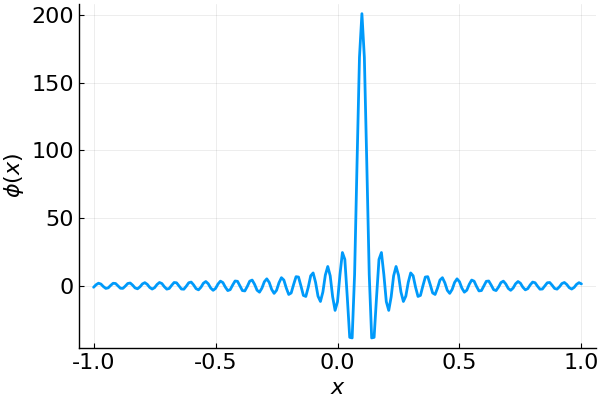

In [1]:
using Plots
using LaTeXStrings
font = Plots.font("Helvetica", 16)
pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)

# Set up a uniform grid on [-1,1] with ngrid grid-points.
Xmax = 1.0
Xmin = -1.0
Length = Xmax - Xmin
ngrid = 201

# Set the maximum k value - increase this to get a more "delta" delta function!
kmax = 100

# Plot the function centered at x=xloc.
xloc = 0.1
x = linspace(Xmin,Xmax,ngrid)
y = zeros(Complex, ngrid)
for i in -kmax:kmax
    y .+= exp.(im * i * (x-xloc))
end

plot(x, real(y), xlim=[Xmin,Xmax],
     xlabel=L"x", ylabel=L"$\phi(x)$",
     lw=2, legend=false)


We see that these basis functions  look like $\delta$-functions centered on each of the positions in the uniform grid; as a result, there are $N$ of these basis functions supported on a uniform grid of $N$ points. 

The Colbert-Miller DVR scheme uses these basis functions, but takes the limit $k \rightarrow \infty$ explicitly when evaluating matrix elements; this is sort of like taking the limit of a infinitely-closely spaced uniform grid. 

The maths is tedious, but the upshot is that the matrix elements in the Colbert-Miller DVR method can be evaluated as follows:

$$
H_{ij} = T_{ij} + V_{ij}
$$

$$
V_{ij} = V(x_{i}) \delta_{ij}
$$

\begin{equation}
\begin{split}
T_{ij} &= \frac{\hbar^{2} (-1)^{(i-j)} \pi^{2}}{6m \Delta x^{2}} \hspace{2cm} \text{if i = j} \\ \\
& = \frac{\hbar^{2} (-1)^{(i-j)} }{m \Delta x^{2} (i-j)^2} \hspace{2cm} \text{if i $\neq$ j}
\end{split}
\end{equation}

Using these equations, it is straightforward to calculate the Hamiltonian matrix elements $H_{ij}$, and to then find the eigenvectors and eigenvalues.


## Example 1: Harmonic oscillator eigenstates and eigenvalues

The potential energy in the 1-D harmonic oscillator is

$$
V(x)=\frac{1}{2}kx^{2} = \frac{1}{2} m \omega^{2} x^{2}
$$

The term  $k$ is the spring constant, which is related to the natural frequency of the oscillator, $\omega$, according to

$$
\omega = \sqrt{\frac{k}{m}}.
$$

The Hamiltonian operator is then

$$
H = -\frac{\hbar^{2}}{2m} \frac{d^{2}}{d x^{2}} + \frac{1}{2} kx^{2}.
$$

The harmonic oscillator is a nice problem because we *know* exactly what the correct eigenfunctions and eigenvalues are (in other words, this is an analytically solvable model). In particular, it turns out that the allowed energy levels of the quantum harmonic oscillator are:

$$
E_{n} = (n+\frac{1}{2}) \hbar \omega, \hspace{3cm} n = 0, 1, 2, \dots
$$

Here, $n$ is a quantum number which identifies the state of the system; the energy spacing between any two adjacent quantum states is $\hbar \omega$.

The eigenfunctions $\psi_{n}(x)$ are all Gaussian functions multipled by *Hermite polynomials*; to see what they look like, consider the following probability distributions:


In [2]:
# Plot of first 4 harmonic oscillator eigenstates (ignoring normalization constants, etc.)
#

# Set up a uniform grid:
Length = 5.0
ngrid = 100
x = linspace(-Length, Length, ngrid)
dx = x[2] - x[1]

# Create array containing first 4 harmonic oscillator eigenstates.
y = zeros(4, ngrid)
y[1, :] = exp.(-0.5x.^2)
y[2, :] = exp.(-0.5x.^2) .* x
y[3, :] = exp.(-0.5x.^2) .* (2*x.^2 - 1)
y[4, :] = exp.(-0.5x.^2) .* (2*x.^3 - 3*x)

# Normalize each function.
for n=1:4
    y[n, :] ./= sqrt(sum(y[n, :].^2 * dx))
end

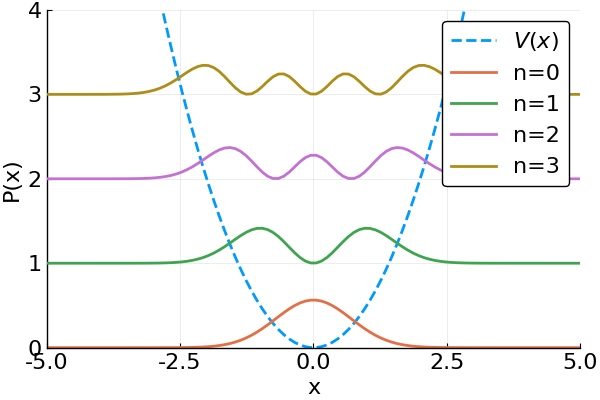

In [4]:
p = plot(x, 0.5*x.^2, label=L"V(x)", 
         xlabel="x", ylabel="P(x)", lw=2, 
         linestyle=:dash, legend=:topright, xlims=(-5, 5), ylims=(0, 4))
for n=1:4
    plot!(x, y[n, :].^2 + (n-1), lw=2, label="n=$(n-1)")
end
display(p)

So, now lets run the Colbert-Miller DVR solution of this problem....

In [5]:
# Set up harmonic oscillator properties - we'll use atomic units, where hbar = 1.0.
#
kspring = 1.0
mass = 1.0
hbar = 1.0

# Set up the uniform grid:
Xmax = 5.0
Xmin = -5.0
Length = Xmax - Xmin
ngrid = 201
x = linspace(Xmin, Xmax, ngrid)
dx = x[2] - x[1]

#
# COLBERT-MILLER DVR HAMILTONIAN CONSTRUCTION.
#
# Set up potential energy matrix.
V = zeros(ngrid, ngrid)
for i = 1:ngrid
    V[i, i] = 0.5 * kspring * x[i]^2
end
diagind

# Set up kinetic energy matrix.
T = zeros(ngrid, ngrid)
for i = 1:ngrid
    for j = 1:ngrid
        if i == j
            T[i, j] = ((hbar^2) * (-1.0)^(i-j) * π^2) / (6 * mass * dx^2 ) 
        else
            T[i, j] = ((hbar^2) * (-1.0)^(i-j)) / (mass * dx^2 * (i-j)^2 )
        end
    end
end

# Create the Hamiltonian matrix:
H = T + V;

We can have a look at the $T$, $V$ and $H$ matrices with the `spy()` plot routine:

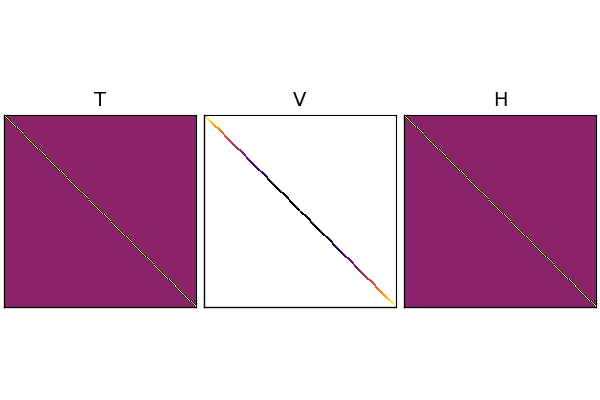

In [6]:
plot(spy(T), spy(V), spy(H), layout=(1, 3), colorbar=false, 
     title=["T" "V" "H"], xticks=nothing, yticks=nothing)

In [7]:
# Solve the eigenvalue problem
E, c = eig(H)

# Print out the first few energy eigenvalues:
@show E[1]
@show E[2]
@show E[3]
@show E[4]

E[1] = 0.5000000000497856
E[2] = 1.5000000024258566
E[3] = 2.5000000565896947
E[4] = 3.5000008395511797


3.5000008395511797

We are using atomic units here (so $\hbar = 1$), and we chose the spring constant and mass of the problem such that $\omega = 1$; this means the expected energy spectrum is $E_{0} = 0.5$, $E_{1} = 1.5$, $E_{2} = 2.5$, and so on. This is exactly what we've calculated above!

**But what about the eigenvectors? Do they look as expected?**


First, it is useful to normalize each eigenfunction such that

$$
\int \, \psi_{i}^{*}(x) \psi_{i}(x) \, dx = 1.
$$

Using simple quadrature, this integral can be evaluated on the uniform grid as

$$
\sum_{j=1}^{N} \psi_{i}^{*}(x_{j}) \psi(x_{j}) \Delta x,
$$

where $\Delta x$ is the grid spacing.

In [8]:
# Normalize each eigenfunction using simple quadrature.
for i = 1:ngrid  
    c[:, i] ./= sqrt(sum(c[:, i].^2 * dx))
end

Now we can plot the DVR eigenvectors.....

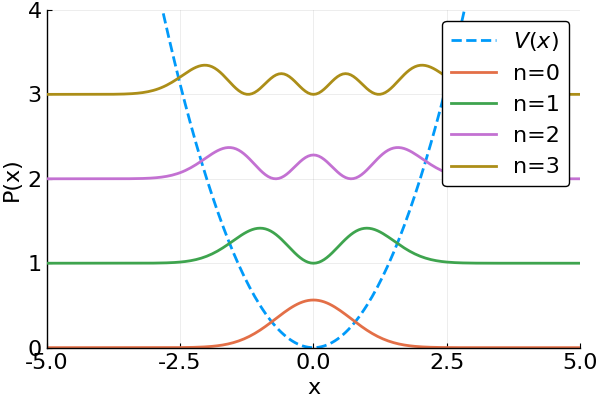

In [10]:
p = plot(x, 0.5*x.^2, label=L"V(x)", 
         xlabel="x", ylabel="P(x)", lw=2, 
         linestyle=:dash, legend=:topright, xlims=(-5, 5), ylims=(0, 4))
for n=1:4
    plot!(x, c[:, n].^2 + (n-1), lw=2, label="n=$(n-1)")
end
display(p)

If you compare the Figure above to the Figure in which we plotted the *analytical* eigenstates for the harmonic oscillator, you'll see that the results are identical!

The conclusion of the above is that the Colbert-Miller DVR code is a convenient numerical method of giving us the eigenvectors and eigenvalues of any 1-dimensional potential. In the *Assignement* for this course, you'll write your won Colbert-Miller code to find the eigenvectors and eigenvalues for a double-well potential energy function.

## Example 2: Quantum dynamics with known eigenvectors

Once we know the eigenvectors and eigenvalues of the system of interest, performing the time-evolution of any initial wavefunction becomes straightforward.

In particular, recall from the first Lecture that the time-dependent Schrodinger equation is

$$
i \hbar \frac{d \psi(x,t)}{dt} = \hat{H} \psi(x,t).
$$

If the system is in some eigenstate $\psi_{i}(x)$ with energy $E_{i}$, then

$$
\hat{H} \psi_{i}(x,t) = E_{i} \psi_{i}(x,t),
$$
so the time-dependent Schrodinger equation becomes

$$
i \hbar \frac{d \psi(x,t)}{dt} = E_{i} \psi(x,t).
$$

the formal solution of which is

$$
\psi(x,t) = e^{-\frac{i E_{i} t}{\hbar}} \psi_{i}(x,0).
$$

It follows that, if a wavefunction can be written as a linear combination of eigenfunctions

$$
\psi_{x} = \sum_{j=1}^{N} c_{j} \phi_{j}(x),
$$

where

$$
\hat{H} \phi_{j} = E_{j} \phi_{j},
$$

then the wavefunction at time $t$ is also a linear combination of eigenfunctions, albeit weighted by different phase  terms arising due to the different energy eigenvalues.

$$
\psi(x,t) = \sum_{j=1}^{N} c_{j} e^{-\frac{i E_{j} t}{\hbar} } \phi_{j}(x) = \sum_{j=1}^{N} c_{j}(t) \phi_{j}(x),
$$

where we have defined the time-dependent coefficients $c_{j}(t)$. Another way of looking at this is that the coefficients $c_{j}$ oscillate with a phase factor $e^{-\frac{i E_{j} t}{\hbar} }$.


### Choice of initial coefficients

How do we choose the initial coefficients $c_{j}(0)$? Suppose we want our linear combination of eigenvectors to represent some wavefunction $\chi(x)$ at time $t=0$:

$$
\chi(x) = \sum_{j=1}^{N} c_{j}(0) \phi_{j}(x)
$$

To find each of the initial coefficients, we simply multiply both sides of the above $\phi^{*}_{m}(x)$ and integrate over $x$; because of the orthonormality of the eigenvectors (see above), the result is that the coefficient $c_{m}(0)$ is given by

$$
c_{m}(0) = \int \phi_{m}^{*}(x) \chi(x) \, dx \simeq \sum_{j=1}^{N} \phi_{m}^{*}(x_{j}) \chi(x_{j}) \Delta x,
$$

where the second equation is the simple quadrature approximation to the integral evaluated on a uniform grid of $N$ points.

We can obviously write down one of these equations for each of the $N$ basis functions, giving us the initial set of coefficients; once we know these, we can propagate the wavefunction as described above.





### Application to harmonic oscillator

Let's use our harmonic oscillator states to propagate a wavefunction. We'll suppose that the initial wavefunction is a Gaussian function centered at $\mu = -2.5$:

$$
\chi(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x - \mu)^{2}}{2 \sigma^{2}}}
$$

** What does the wavefunction look like as a function of time? **

First, let's plot the initial wavefunction....

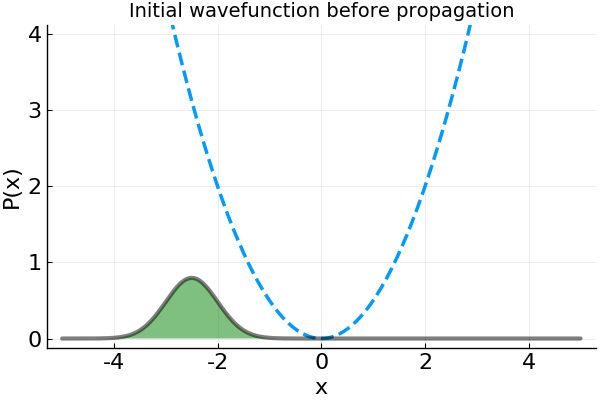

In [11]:
# Initialize wavefunction on grid.
sigma = 0.5
mu = -2.5
chi = (1.0/(sigma*(sqrt(2*π)))) * exp.(-0.5 * (x - mu).^2/sigma^2)
plot(x, 0.5*x.^2, linewidth=2.5, linestyle=:dash, xlabel="x", ylabel="P(x)",
        ylims=[0,4], xlabel="x", legend=false)
plot!(x, chi, fillrange=0, fillcolor=:green, alpha=0.5, color=:black, lw=3)
title!("Initial wavefunction before propagation")

Now, we've already calculated the eigenvectors for the harmonic potential; we'll write the time-evolving wavefunction as a linear combination of these eigenvectors.

We just need to work out the initial expansion coefficients, as described above; we'll also plot the wavefunction as represented by the linear combination against the original wavefunction to check that they match...

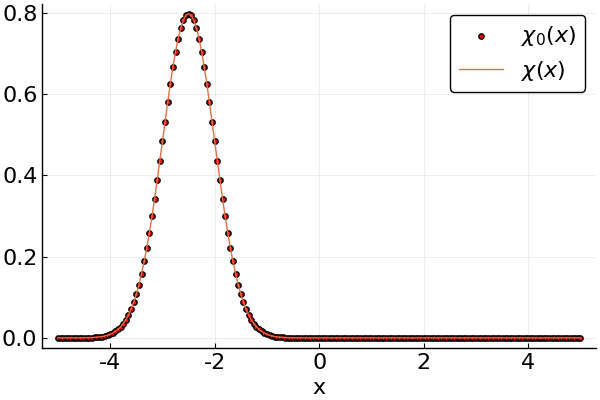

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [13]:
# Calculate the expansion coefficients of each eigenvector using simple integration.
#
coeff = zeros(Complex, ngrid)
for i = 1:ngrid
    coeff[i] = sum(chi .* c[:, i]) * dx
end

# Plot the initial wavefunction, as described by the linear combination of eigenvectors - 
# this should be the same as the Gaussian above.
#
chi0 = zeros(Complex, ngrid)
for i = 1:ngrid
    chi0[i] = sum(coeff .* c[i, :])
end

pyplot()
scatter(x, real(chi0), color=:red, marker=:o, label=L"\chi_0(x)")
plot!(x, chi, xlabel="x", label=L"\chi(x)")

Now we know the initial coefficients, we can plot the wavefunction at ANY later time $t$! Let's try it...

In [17]:
# Define a function to compute wavefunction at time t
wavefunction(t) = sum(c[:, j] * coeff[j] * exp.(-im * E[j] * t/hbar) for j=1:ngrid)

# Let's plot the wavefunction over time from t = 0.0 to 3.0.
gr(fmt=:png) # use GR backend for animations as it's faster than pyplot

@gif for tt in 0.0:0.05:3.0
    plot(x, [0.5*x.^2 abs.(wavefunction(tt))], lw=3, legend=false,
         linestyle=[:dash :solid], color=[:blue :black], xlabel="x", ylabel="P(x)",
         fillrange=[0 0], fillcolor=[:white :green], alpha=0.5, ylim=(0, 2))
end

INFO: Saved animation to /home/eng/essswb/.iatl/modules/IL027-dev/IL027-dev/InterdisciplinaryComputing/L5/tmp.gif


Plots.AnimatedGif("/home/eng/essswb/.iatl/modules/IL027-dev/IL027-dev/InterdisciplinaryComputing/L5/tmp.gif")

## Summary

In this section, we learnt about how we can solve the Schrodinger equation for simple 1-dimensional systems, and how we can propagate wavefunctions once we know the eigenvectors and eigenvalues.

In the assessed work, you will build on these methods; first, you'll implement your own Colbert-Miller DVR for a different 1-dimensional model system, and you'll also learn about the split-operator Fourier transform method for propagating wavefunctions *without* requiring the eigenfunctions.
